In [1]:
import os
import sys
import pandas as pd
import numpy as np
import gzip
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
import random

In [2]:
roll_list = list()

In [3]:
class students:
  
    # The images are 50 pixels in each dimension.
    img_size = 50

    # The images are stored in one-dimensional arrays of this length.
    img_size_flat = img_size * img_size

    # Tuple with height and width of images used to reshape arrays.
    img_shape = (img_size, img_size)

    # Number of colour channels for the images: 1 channel for gray-scale.
    num_channels = 1

    # Tuple with height, width and depth used to reshape arrays.
    # This is used for reshaping in Keras.
    img_shape_full = (img_size, img_size, num_channels)

    # Number of classes, one class for each of 10 digits.
    # num_classes = 
    
    dirc = input("Enter subject code:")
    
    def __init__(self):      
        
        cv_img_train = []
        class_name = []
        m = 0
        
        for img in glob.glob("E:\\"+self.dirc+"\*\*.jpg"):
            i= cv2.imread(img)
            if type(i) != np.ndarray:
                continue
            m += 1;
        
        images = np.zeros((m,self.img_size_flat))
        n = 0
        
        for img in glob.glob("E:\\"+self.dirc+"\*\*.jpg"):        
            i= cv2.imread(img)
            if type(i) != np.ndarray:
                continue
            i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            i = cv2.resize(i, (self.img_size, self.img_size))
            i = i.flatten() 
            images[n] = i
            n += 1
            
            class_name.append(img.split('\\')[2])
                
        unique_class = set(class_name)
        unique_class = list(unique_class)
        
        for a in unique_class:
            roll_list.append(a)
        
        print("Printing roll numbers of registered students:")
        print(unique_class)
        
        self.num_classes = len(np.unique(unique_class))
        print("Printing number of registered students: ",self.num_classes)
        
        x_train = images
        
        y_train_cls = np.asarray(class_name)
        
        self.num_train = len(x_train)
        print("Length of training set: ",self.num_train)
         
        correct_vals = np.zeros((m,self.num_classes))
        
        y_train = np.zeros(m)
        
        d = {k: v for v, k in enumerate(unique_class)}
        
        self.d = d
        
        print("Keys assigned to different roll numbers:")
        print(d)
        
        for i in range(0,len(y_train_cls)):
            for breed,index in d.items():
                if breed == y_train_cls[i]:
                    
                    y_train[i] = index
                    correct_val = np.zeros((self.num_classes))
                    correct_val[index] = 1
                    correct_vals[i] = correct_val
                     
        y_train_cls= correct_vals
            
        self.x_train = x_train[0:self.num_train] / 255.0
        self.y_train_cls = y_train_cls[0:self.num_train]
        self.y_train = y_train[0:self.num_train]
        
        
    def random_batch(self, batch_size=32):
        """
        Create a random batch of training-data.
        :param batch_size: Number of images in the batch.
        :return: 3 numpy arrays (x, y, y_cls)
        """
        act_idx=np.arange(self.num_train)
        
        # Create a random index into the training-set.
        idx = np.random.choice(self.num_train, batch_size, replace=False)
        non_idx = np.setdiff1d(act_idx, idx)
        
        # Use the index to lookup random training-data.
        
        x_batch = self.x_train[idx]
        
        y_batch_cls = self.y_train_cls[idx]
        
        x_batch_test = self.x_train[non_idx]
        
        y_batch_cls_test = self.y_train_cls[non_idx]
        
        y_test = self.y_train[non_idx]

        return x_batch, y_batch_cls, x_batch_test,y_batch_cls_test,y_test

Enter subject code:AI61005


In [4]:
data = students()

Printing roll numbers of registered students:
['19IM3FP26', '19EE10068', '19CY20001', '19EE10059', '19ME10033', '19CH10066', '19EE10078']
Printing number of registered students:  7
Length of training set:  700
Keys assigned to different roll numbers:
{'19IM3FP26': 0, '19EE10068': 1, '19CY20001': 2, '19EE10059': 3, '19ME10033': 4, '19CH10066': 5, '19EE10078': 6}


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [6]:
img_size = data.img_size
print("img_size : ",img_size)

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat
print("img_size_flat : ",img_size_flat)

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape
print("img_shape : ",img_shape )

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes
print("num_classes : ",num_classes)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels
print("num_channels : ",num_channels)

img_size :  50
img_size_flat :  2500
img_shape :  (50, 50)
num_classes :  7
num_channels :  1


In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [8]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    
    # The padding is set to 'SAME' which means the input image is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, filter_size/2, filter_size/2, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution.
    
    if use_pooling:
        
        # This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value in each window. 
        #Then we move 2 pixels to the next window.
        
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # We return both the resulting layer and the filter-weights because we will plot the weights later.
    return layer, weights

In [100]:
def flatten_layer(layer):
    
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    print(layer_shape)
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    print(num_features)
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    print(layer_flat.shape)
    
    # The shape of the flattened layer is now: [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [101]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU.
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [102]:
tf.compat.v1.disable_eager_execution()

In [103]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x.shape

TensorShape([None, 2500])

In [104]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
x_image.shape

TensorShape([None, 50, 50, 1])

In [105]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true.shape

TensorShape([None, 5])

In [106]:
y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls

<tf.Tensor 'ArgMax_4:0' shape=(None,) dtype=int64>

In [107]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=5,
                   num_filters=16,
                   use_pooling=True)

In [108]:
layer_conv1

<tf.Tensor 'Relu_6:0' shape=(None, 13, 13, 16) dtype=float32>

In [109]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=16,
                   filter_size=3,
                   num_filters=36,
                   use_pooling=True)

In [110]:
layer_conv2

<tf.Tensor 'Relu_7:0' shape=(None, 7, 7, 36) dtype=float32>

In [111]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

(None, 7, 7, 36)
1764
(None, 1764)


<tf.Tensor 'Reshape_5:0' shape=(None, 1764) dtype=float32>

In [113]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=128,
                         use_relu=True)

In [114]:
layer_fc1

<tf.Tensor 'Relu_9:0' shape=(None, 128) dtype=float32>

In [115]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=128,
                         num_outputs=num_classes,
                         use_relu=False)

In [116]:
layer_fc2

<tf.Tensor 'add_12:0' shape=(None, 5) dtype=float32>

In [117]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred

<tf.Tensor 'Softmax_2:0' shape=(None, 5) dtype=float32>

In [118]:
y_pred_cls = tf.argmax(y_pred, axis=1)
y_pred_cls

<tf.Tensor 'ArgMax_5:0' shape=(None,) dtype=int64>

In [119]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [120]:
cost = tf.reduce_mean(cross_entropy)

In [121]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [122]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [123]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [124]:
session = tf.Session()

In [125]:
session.run(tf.global_variables_initializer())

In [126]:
train_batch_size = data.num_train

In [127]:
x_batch, y_true_batch,x_batch_test,y_batch_cls_test,y_test = data.random_batch(batch_size=train_batch_size)

In [128]:
total_iterations = 0

def optimize(num_iterations,x_batch, y_true_batch):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

       
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
   
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [129]:
num_iterations=800
optimize(num_iterations,x_batch, y_true_batch)

Optimization Iteration:      1, Training Accuracy:  20.0%
Optimization Iteration:    101, Training Accuracy:  99.4%
Optimization Iteration:    201, Training Accuracy:  99.8%
Optimization Iteration:    301, Training Accuracy: 100.0%
Optimization Iteration:    401, Training Accuracy: 100.0%
Optimization Iteration:    501, Training Accuracy: 100.0%
Optimization Iteration:    601, Training Accuracy: 100.0%
Optimization Iteration:    701, Training Accuracy: 100.0%
Time usage: 0:02:56


In [142]:
def plot_images(images, cls_true, cls_pred=None):
    
    #assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.9, wspace=0.9)

    for i, ax in enumerate(axes.flat):
        
        # Plot image.
        ax.imshow(images[i].reshape((50,50,3)),cmap='brg')

        # Show true and predicted classes.
        # if cls_pred is None:
        #      xlabel = "True: {0}".format(cls_true[i])
        #  else:
        #      xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel("Images from test data")
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [143]:
cv_img_train = []
class_name = []

m = 0

for img in glob.glob("E:/test/*.jpg"):
    i = cv2.imread(img)
    if type(i) != np.ndarray:
        continue
    m += 1;
                
#img_size_flat = self.img_size*self.img_size    

images = np.zeros((m,2500))
n = 0
x_batch_test_color = []
    
for img in glob.glob("E:/test/*.jpg"):  
    
    i= cv2.imread(img)
    
    if type(i) != np.ndarray:
        continue
    
    x_batch_test_color.append(cv2.resize(i, (50, 50)))    
    
    i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    i = cv2.resize(i, (50, 50))
    i = i.flatten() 
    
    images[n]= i
    
    n += 1

x_test = images 
x_batch_test = x_test / 255.0

y_batch_cls_test = []
y_test =[]

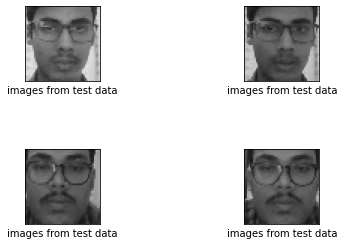

In [144]:
plot_images(x_batch_test_color,y_test,None)

In [145]:
def plot_conv_layer(layer, image):
    
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        
        # Only plot the images for valid filters.
        
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

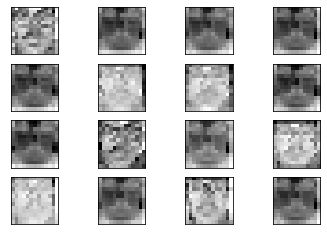

In [146]:
image1 = x_batch_test[10]

plot_conv_layer(layer=layer_conv1, image=image1)

In [147]:
def predicted_labels_scores( x_batch_test,y_batch_cls_test,y_test):
                       
    # Number of images in the test-set.
    # num_test = data.num_train - train_batch_size
    
    num_test = len(x_test)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    images = x_batch_test[:, :]
    labels = y_batch_cls_test
    
    feed_dict = {x: images}

    # score for all classes for all the images
    cls_pred = session.run(y_pred, feed_dict=feed_dict)
    
    # maximum score of all classes for all the  image 
    cls_pred_max = session.run(y_pred_cls,feed_dict=feed_dict)
        
        
    # setting a threshold value of scores below which object is labelled as from class 100 which shows that image cannot be surely classified to any class.
    # This is done in order to prevent present marking against the student who is not present.
        
    for p in range(0,num_test):
        if np.amax(cls_pred[p]) < 0.85:
            cls_pred_max[p] =100
          
    return cls_pred,cls_pred_max    

In [148]:
cls_pred_test,cls_pred_max_test=predicted_labels_scores(x_batch_test,y_batch_cls_test,y_test)

In [149]:
#getting the unique values and how many images in test set are assigned these unique values 

unique, counts = np.unique(cls_pred_max_test, return_counts=True)

dict(zip(unique, counts))

{1: 90, 3: 72}

In [163]:
li =[]

for i in range(0,len(unique)):
    for roll,index in data.d.items():
        if index == unique[i]:
            li.append(roll) 
            
li

['19EE10078', '19EE10068']

In [158]:
classlist = roll_list.copy()
classlist = np.array(classlist)
classlist = np.unique(classlist)

df = pd.DataFrame()

df['Roll_numbers'] = classlist

In [161]:
date = input('Enter date:')

df[date] = 0

for i in li:
    for k in range(0,len(classlist)):
        if df.Roll_numbers[k] == i:
            df[date][k] = 1

df.to_csv('E:/Attendance.csv')

Enter date:8


<ipython-input-161-548c12f5ff2c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date][k] = 1


In [162]:
df

,Roll_numbers,7,8
0,19CH10066,0,0
1,19CY20001,0,0
2,19EE10059,0,0
3,19EE10068,1,1
4,19EE10078,1,1
